# 文章のベクトル化と単語のベクトル化を分類し、統計手法と分散表現に分けた表形式

| **分類**          | **手法タイプ**  | **手法名**                      | **説明**                                                                 |
|--------------------|----------------|----------------------------------|---------------------------------------------------------------------------|
| **文章のベクトル化** | 統計手法        | Bag of Words (BoW)              | 文書内の単語出現回数をカウントし、高次元の疎なベクトルとして表現する。        |
|                    |                | TF-IDF                          | BoWに重み付けを加え、単語の重要度を考慮した手法。                           |
|                    | 分散表現        | Doc2Vec                         | 文書全体を意味的に表現するための分散表現。PV-DMやPV-DBOWが含まれる。           |
| **単語のベクトル化** | 統計手法        | One-Hot Encoding                | 単語をバイナリベクトルとして表現。意味的な情報は含まれない。                   |
|                    | 分散表現        | Word2Vec                        | 単語の意味を文脈から学習。Skip-gramとCBOWの2つのアプローチがある。            |
|                    |                | GloVe                           | 単語の共起情報を用いた分散表現。                                             |
|                    |                | FastText                        | 単語をサブワードに分割し、稀な単語や未登録語にも対応可能な手法。                |
|                    |                | Transformer Embeddings (BERT等) | 深層学習に基づく文脈を考慮した単語ベクトル。BERTやGPTが含まれる。              |

![世代別のテキストベクトル化手法](https://github.com/necococo/images/blob/main/NLP%E6%9C%80%E8%BF%91%E3%81%AE%E3%83%99%E3%82%AF%E3%83%88%E3%83%AB%E5%8C%96%E6%89%8B%E6%B3%95.png?raw=true)
引用 [「Sentence Embeddings」松尾研 LLM コミュニティ "Paper & Hacks Vol.32"](https://www.youtube.com/watch?v=4M1ykCjzAC8)

# 問題１：

記事データを読み込み、記事本文から名詞を抽出してください。
各記事について、出現頻度が高い上位10個の名詞を抽出し、棒グラフで可視化してください。
記事本文をベクトル化し、コサイン類似度を用いて記事間の類似度を計算してください。
計算結果に基づいて、最も類似度の高い記事のペアを3組出力してください。

# 問題２：
レビューデータを読み込み、レビュー本文から形容詞を抽出してください。
各商品について、出現頻度が高い上位5個の形容詞を抽出し、円グラフで可視化してください。
レビュー本文を形態素解析し、感情分析（ポジティブ/ネガティブ）を行ってください。
各商品のレビューの感情スコア（ポジティブなレビューの割合 - ネガティブなレビューの割合）を計算し、棒グラフで可視化してください。

# 問題３：
投稿データを読み込み、投稿本文から動詞を抽出してください。
各ユーザーについて、出現頻度が高い上位5個の動詞を抽出し、折れ線グラフで可視化してください。
投稿本文をTF-IDFでベクトル化し、K-means法を用いてユーザーを3つのクラスタに分類してください。
各クラスタの特徴を分析し、クラスタに名前を付けてください。

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
# @title
!apt-get update

# mecab関係のインストール
!apt-get -y install mecab libmecab-dev
#   - mecab: MeCab 本体です。
#   - libmecab-dev: MeCab の開発用ライブラリです。Python バインディングのインストールに必要です。

# インストールの確認
!which mecab # /usr/bin/mecab と表示されればOK
!mecab-config --dicdir # MeCabのインストールディレクトリ /usr/lib/x86_64-linux-gnu/mecab/dic と表示されればOK
# mecab-config --dicdir は、MeCab の辞書ディレクトリを表示します。このディレクトリに辞書がインストールされます。

## Neologd 辞書(最近の単語の辞書)のインストール
### このスクリプトは、デフォルトではNeologd辞書をMeCabのインストールディレクトリ(/usr/lib/x86_64-linux-gnu/mecab/dic)にインストールします。
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git

!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n
#   - echo yes: yes という文字列を出力します。
#   - | (パイプ): 前のコマンドの出力を次のコマンドの入力に渡します。
#   - mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd: Neologd 辞書のインストールスクリプトです。
#   - -n: インストール時の質問にすべて no で答えるオプションです。ここでは yes をパイプで渡しているので、実質的にすべての質問に yes で答えることになります。

# Python バインディングのインストール
# PythonからMeCabを利用するためのインターフェース（バインディング）です。これにより、PythonのプログラムからMeCabの機能を利用できるようになります。
!pip install mecab-python3

!mkdir -p /usr/local/etc # /usr/local/etc は、設定ファイルなどを保存するためのディレクトリとして一般的に使用されます。
!echo "dicdir = /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd" > /usr/local/etc/mecabrc # MeCab が使用する辞書を指定するため
#   - > /usr/local/etc/mecabrc: 出力結果を /usr/local/etc/mecabrc ファイルに書き込みます。これにより、MeCab の設定ファイルが作成され、Neologd 辞書のパスが設定されます。


# matplotlib の日本語表示改善 (必要に応じて)
!pip install japanize-matplotlib
!pip install --upgrade scikit-learn
!pip install gensim

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,642 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,227 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/univer

In [ ]:
# 動作テスト

import MeCab

mecab = MeCab.Tagger("-Ochasen -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")
result = mecab.parse("かわちぃ")
print(result)

か	カ	か	助詞-副助詞／並立助詞／終助詞		
わ	ワ	わ	助詞-終助詞		
ちぃ	チィ	ちぃ	名詞-固有名詞-人名-一般		
EOS



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import MeCab
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# from janome.tokenizer import Tokenizer
# from janome.analyzer import Analyzer
# from janome.charfilter import *
# from janome.tokenfilter import *
# from gensim.models import Word2Vec

In [ ]:
data1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/PKSHA/ex1.csv")
data1.head()

,記事ID,記事タイトル,記事本文,カテゴリ
0,1,AI技術の最新動向,AI技術は近年急速に進歩しており、様々な分野で活用が進んでいます。,テクノロジー
1,2,株価急騰の背景,〇〇社の株価が急騰しています。その背景には、新規事業の成功が挙げられます。,経済
2,3,新型スマートフォンの発売,〇〇社は、新型スマートフォンを発売しました。,テクノロジー
3,4,来年の経済見通し,専門家は、来年の経済見通しについて、〇〇という見解を示しています。,経済
4,5,話題のAI搭載ロボット,AIを搭載したロボットが話題になっています。,テクノロジー


In [ ]:
import re

def extract_words_by_pos(text, target_pos=["名詞", "動詞", "形容詞", "形容動詞", "副詞"], stop_words=['〇']):
# posは品詞の英語表現 'part of speech'の略
    """
    テキストから指定された品詞の単語を抽出する関数

    Args:
        text: 解析対象のテキスト (str)
        target_pos: 抽出したい品詞 (str, default="名詞")
        stop_words: 除外したい単語のリスト (list, default=[])

    Returns:
        list: 指定された品詞の単語のリスト
    """
    mecab = MeCab.Tagger()
    node = mecab.parseToNode(text)

    extracted_words = []
    while node:
        features = node.feature.split(',')
        # print(f"{features[0]=}")
        if features[0] in target_pos: # node.featureには品詞以外にも、品詞細分類、活用形、活用型、原形などの情報  例：動詞,自立,*,*,五段・マス形,基本形,食べる,タベル,タベル
            extracted_word = features[6] # 単語の原型が登録されている

            if not any(re.match(pattern, extracted_word) for pattern in stop_words):
                extracted_words.append(extracted_word)
        node = node.next
    return extracted_words

text = "〇 AI技術は近年急速に進歩しており、/〇様々な分野で活用が進んでいます〇。〇〇。"

print(extract_words_by_pos(text, target_pos=["名詞"], stop_words=['〇']))


['AI', '技術', '近年', '急速', '進歩', '様々', '分野', '活用']


In [ ]:
data1['名詞'] = data1['記事本文'].apply(lambda text: extract_words_by_pos(text, target_pos="名詞", stop_words=['〇'])) # data1から'記事本文'集合を取り出し、その要素をtextと呼びます。textごとに関数extract_words_by_posを適用します。
print(data1.head())

   記事ID        記事タイトル                                   記事本文    カテゴリ  \
0     1     AI技術の最新動向      AI技術は近年急速に進歩しており、様々な分野で活用が進んでいます。  テクノロジー   
1     2       株価急騰の背景  〇〇社の株価が急騰しています。その背景には、新規事業の成功が挙げられます。      経済   
2     3  新型スマートフォンの発売                 〇〇社は、新型スマートフォンを発売しました。  テクノロジー   
3     4      来年の経済見通し      専門家は、来年の経済見通しについて、〇〇という見解を示しています。      経済   
4     5   話題のAI搭載ロボット                 AIを搭載したロボットが話題になっています。  テクノロジー   

                                 名詞  
0  [AI, 技術, 近年, 急速, 進歩, 様々, 分野, 活用]  
1       [社, 株価, 急騰, 背景, 新規, 事業, 成功]  
2           [社, 新型, smartphone, 発売]  
3            [専門家, 来年, 経済, 見通し, 見解]  
4                [AI, 搭載, ロボット, 話題]  


('AI', '社', '技術') (2, 2, 1)


Text(0.5, 1.0, 'データ全体での名詞出現頻度トップ3')

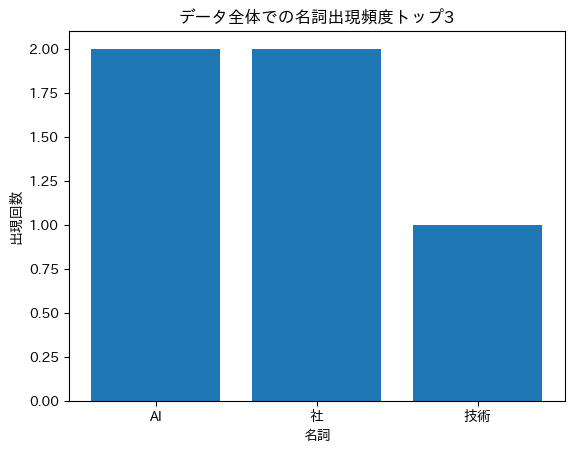

In [ ]:
from collections import Counter

# def add_count_pos(df, pos_column='名詞'):
#     df[pos_colum + 'count'] = df[pos_column].apply(lambda x: Counter(x))
#     return df

all_nouns = []
for nouns in data1['名詞']:
    all_nouns.extend(nouns)
    # appendだとリストがそのままリストに追加されてしまいリストのリストになってしまう。


top3_words = Counter(all_nouns).most_common(3)
# top3_words = [('AI', 2), ('社', 2), ('技術', 1)]
words, counts = zip(*top3_words) # *top3_words は、要素である「タプルを展開して」、zip() 関数に渡しています。
print(words, counts )
# words=('AI', '技術', '社'), counts=(2, 1, 2)。
# zip(*top3_words) = zip(('AI', 2), ('技術', 1), ('社', 2)) ≠ zip([('AI', 2), ('技術', 1), ('社', 2)]) = zip(top3_words)

plt.bar(words, counts)
plt.xlabel('名詞')
plt.ylabel('出現回数')
plt.title('データ全体での名詞出現頻度トップ3')


In [ ]:
df = data1.copy()
mecab = MeCab.Tagger()
df['分かち書き'] = df['記事本文'].apply(lambda text: mecab.parse(text).strip())
vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(df['分かち書き'])
tfidf_similarity = cosine_similarity(tfidf_vectors)
print(tfidf_similarity)

[[1.         0.40360199 0.29983655 0.34713005 0.44829738]
 [0.40360199 1.         0.47306743 0.38871464 0.41383985]
 [0.29983655 0.47306743 1.         0.26845254 0.28971834]
 [0.34713005 0.38871464 0.26845254 1.         0.34577798]
 [0.44829738 0.41383985 0.28971834 0.34577798 1.        ]]


In [ ]:
!pip install transformers

In [ ]:
# gpt2でベクトル化
from transformers import AutoTokenizer, AutoModel
import torch

model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_sentence_vector(text):
    inputs = tokenizer(text, return_tensors='pt') # pt='p'y't'orch
    outputs = model(**inputs, output_hidden_states=True) # inputs = {'input_ids': ...,'attention_mask': ...}の辞書型なので**で展開する。

    # 最初のトークンのベクトルを取得 gpt3でいうところの[CLS]みたいなもの
    embeddings = outputs.hidden_states[-1][:, 0, :] # [b, n_tokens, emb_dim]
    # # 最後の隠れ状態ベクトルの平均を計算
    # embeddings = torch.mean(outputs.hidden_states[-1], dim=1)
    return embeddings[0].detach().numpy() # [0]はバッチ次元を無視するためのもの  [1, 埋め込み次元] ---> [埋め込み次元]

df['ベクトル'] = df['記事本文'].apply(get_sentence_vector)

vectors = df['ベクトル'].to_list()
similarity_matrix = cosine_similarity(vectors)
print(similarity_matrix)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

[[1.         0.97713464 0.97713464 0.9861843  1.        ]
 [0.97713464 0.99999994 0.99999994 0.991855   0.97713464]
 [0.97713464 0.99999994 0.99999994 0.991855   0.97713464]
 [0.9861843  0.991855   0.991855   1.0000004  0.9861843 ]
 [1.         0.97713464 0.97713464 0.9861843  1.        ]]


\* と ** はどちらもPythonの展開演算子といいます。展開する対象と用途が異なり以下のようです。

    *
    展開する対象: リストやタプルなどの iterable なオブジェクト
    用途:
        関数定義：可変長の位置引数を受け取る
        関数呼び出し：iterableなオブジェクトの要素を位置引数として展開
        リスト内包表記など：iterableなオブジェクトの要素を展開

    **
    展開する対象: 辞書型のオブジェクト
    用途:
        関数定義：可変長のキーワード引数を受け取る
        関数呼び出し：辞書型のオブジェクトのキーと値をキーワード引数として展開

In [ ]:
df = data1.copy()
mecab = MeCab.Tagger()
df['分かち書き'] = df['記事本文'].apply(lambda text: mecab.parse(text).strip())
vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(df['分かち書き'])
tfidf_similarity = cosine_similarity(tfidf_vectors)
# print(f"{tfidf_similarity=}")
indices = np.triu_indices(len(tfidf_similarity), k=1)
# k=1 は、対角線上の要素を 除外 することを意味します。
# indices=(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([1, 2, 3, 4, 2, 3, 4, 3, 4, 4]))
# 最初の要素 (0, 1) は、0行1列目の要素に対応します。2番目の要素 (0, 2) は、0行2列目の要素に対応します。
# print(f"{indices=}")
similarity_values = tfidf_similarity[indices]
# print(similarity_values)
sorted_indices = np.argsort(similarity_values)[::-1]
# print(f"{sorted_indices=}")

# 上位3つのペアを出力
for i in range(3):
    row_index, col_index = indices[0][sorted_indices[i]], indices[1][sorted_indices[i]]
    print(f"記事ID {row_index + 1}　と {col_index + 1}　(類似度: {tfidf_similarity[row_index, col_index]:.4f})")

記事ID 2　と 3　(類似度: 0.4731)
記事ID 1　と 5　(類似度: 0.4483)
記事ID 2　と 5　(類似度: 0.4138)


問題２：
レビューデータを読み込み、レビュー本文から形容詞を抽出してください。 各商品について、出現頻度が高い上位5個の形容詞を抽出し、円グラフで可視化してください。 レビュー本文を形態素解析し、感情分析（ポジティブ/ネガティブ）を行ってください。 各商品のレビューの感情スコア（ポジティブなレビューの割合 - ネガティブなレビューの割合）を計算し、棒グラフで可視化してください。

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/PKSHA/ex2.csv")
df2.head()

,レビューID,商品ID,レビュー本文,評価
0,1,1,この商品は使いやすくて、とても気に入りました。,5
1,2,1,値段の割に性能が良く、満足しています。,4
2,3,2,デザインは良いのですが、少し使いづらいです。,3
3,4,2,期待していたほどではありませんでした。,2
4,5,3,とても良い商品です。買って良かったです。,5


In [ ]:
df2['形容詞'] = df2['レビュー本文'].apply(lambda text: extract_words_by_pos(text, target_pos='形容詞'))
df2.head(5)

,レビューID,商品ID,レビュー本文,評価,形容詞
0,1,1,この商品は使いやすくて、とても気に入りました。,5,[やすい]
1,2,1,値段の割に性能が良く、満足しています。,4,[良い]
2,3,2,デザインは良いのですが、少し使いづらいです。,3,"[良い, づらい]"
3,4,2,期待していたほどではありませんでした。,2,[]
4,5,3,とても良い商品です。買って良かったです。,5,"[良い, 良い]"


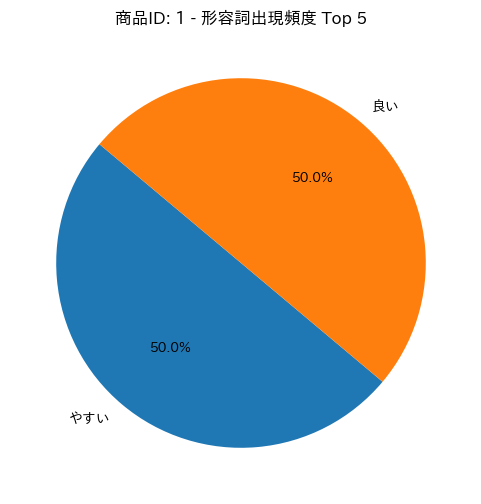

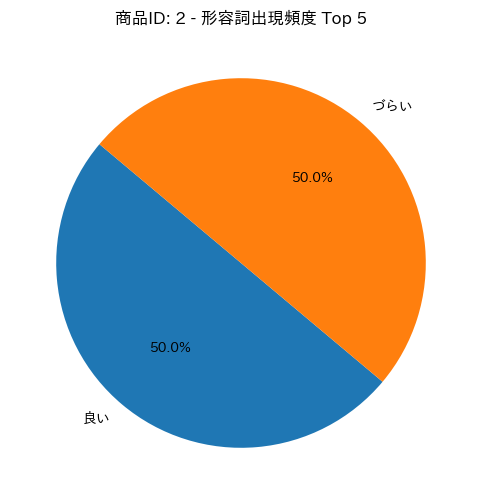

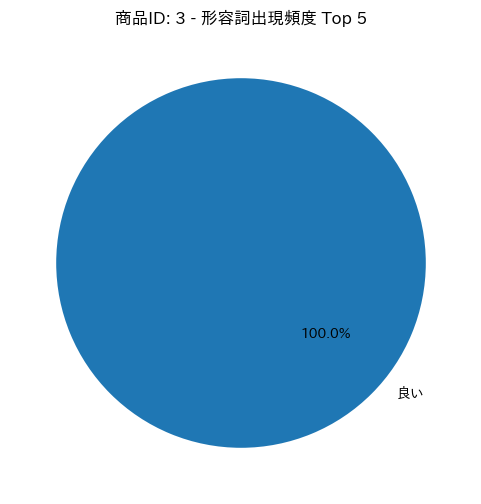

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def analyze_adjectives(df, item_id, top_n=5):
    """
    レビューデータから形容詞を抽出し、出現頻度が高い上位top_n個の形容詞を円グラフで可視化します。

    Args:
        df (DataFrame): レビューデータを含むDataFrame。
        item_id (int): 商品ID。
        top_n (int): 表示する形容詞の数。デフォルトは5。
    """
    all_adjectives = []
    for adjectives in df[df['商品ID'] == item_id]['形容詞']:
        all_adjectives.extend(adjectives)

    top_adjectives = Counter(all_adjectives).most_common(top_n)
    words, counts = zip(*top_adjectives)

    plt.figure(figsize=(6, 6))  # グラフサイズを調整
    plt.pie(counts, labels=words, autopct="%1.1f%%", startangle=140)
    plt.title(f"商品ID: {item_id} - 形容詞出現頻度 Top {top_n}")  # タイトルを追加
    plt.show()

"""
autopct="%1.1f%%" (例えば、30.5%、12.3%)

%1.1f%% :  これが書式指定文字列です。

% : パーセント記号を表示します。
1.1f : 数値をフォーマットします。
1 : 全体の文字幅（最低1桁）を指定します。
. : 小数点を表示します。
1 : 小数点以下の桁数を指定します（ここでは1桁）。
f : 浮動小数点数型で表示します。
%% : % を文字として表示します。
"""

for item_id in df2['商品ID'].unique():  # unique()メソッドで重複排除
    analyze_adjectives(df2, item_id)

In [ ]:
!wget https://www.cl.ecei.tohoku.ac.jp/resources/sent_lex/wago.121808.pn -P "/content/drive/MyDrive/Colab Notebooks/data/PKSHA"

--2025-01-16 13:17:32--  https://www.cl.ecei.tohoku.ac.jp/resources/sent_lex/wago.121808.pn
Resolving www.cl.ecei.tohoku.ac.jp (www.cl.ecei.tohoku.ac.jp)... 130.34.192.83
Connecting to www.cl.ecei.tohoku.ac.jp (www.cl.ecei.tohoku.ac.jp)|130.34.192.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181686 (177K)
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/data/PKSHA/wago.121808.pn.7’

wago.121808.pn.7    100%[===================>] 177.43K   563KB/s    in 0.3s    

2025-01-16 13:17:33 (563 KB/s) - ‘/content/drive/MyDrive/Colab Notebooks/data/PKSHA/wago.121808.pn.7’ saved [181686/181686]



In [ ]:
sentiment_dict = {}
with open('/content/drive/MyDrive/Colab Notebooks/data/PKSHA/wago.121808.pn', 'r', encoding='utf-8') as f:
    for line in f:
        # print(line)
        try:
            polarity, word = line.strip().split('\t')
            if word not in sentiment_dict:
                sentiment_dict[word] = []
            sentiment_dict[word].append(polarity)
        except ValueError:
            pass
# print(sentiment_dict)
# for k, v in sentiment_dict.items():
#     # if len(v) > 1:
#     print(k, v)

In [ ]:
polarity_dict = {
    "ポジ（評価）": 1,
    "ポジ（経験）": 1,
    "ネガ（評価）": -1,
    "ネガ（経験）": -1
}

def get_polarity_score(polarity_list):
    score = 0
    for p in polarity_list:
        # print(p)
        score += polarity_dict.get(p, 0)  # 辞書にない場合は0を返す
        # print(score)
    return score

sentiment_dict_new = {}
for word, polarity_list in sentiment_dict.items():
    score = get_polarity_score(polarity_list)
    sentiment_dict_new[word] = score

print(next(iter(sentiment_dict_new.items()))) # ('あがく', -1)
print(sentiment_dict_new['買い得 です']) # 0
print(sentiment_dict_new.get('商品', 0))

('あがく', -1)
0
0


In [ ]:
def text_polarity(text, target_pos=["名詞", "動詞", "形容詞", "形容動詞", "副詞"], stop_words=["◯"], polarity_dict={}):
    """
    テキストの極性スコアを計算する関数

    Args:
        text: 解析対象のテキスト (str)
        target_pos: 抽出したい品詞 (list, default=["名詞", "動詞", "形容詞", "形容動詞", "副詞"])
        stop_words: 除外したい単語のリスト (list, default=[])
        polarity_dict: 単語の極性値を格納した辞書 (dict, default={})

    Returns:
        float: テキストの極性スコア
    """
    # 抽出された単語を取得
    extracted_words = extract_words_by_pos(text, target_pos, stop_words)

    # 単語の極性値を計算
    word_polarities = sum(polarity_dict.get(word, 0) for word in extracted_words)
    word_count = len(extracted_words)

    # 平均極性値を返す
    return word_polarities / word_count if word_count > 0 else 0


text = "値段の割に性能が良く、満足しています。"

print(text_polarity(text, polarity_dict=sentiment_dict_new))

0.2857142857142857


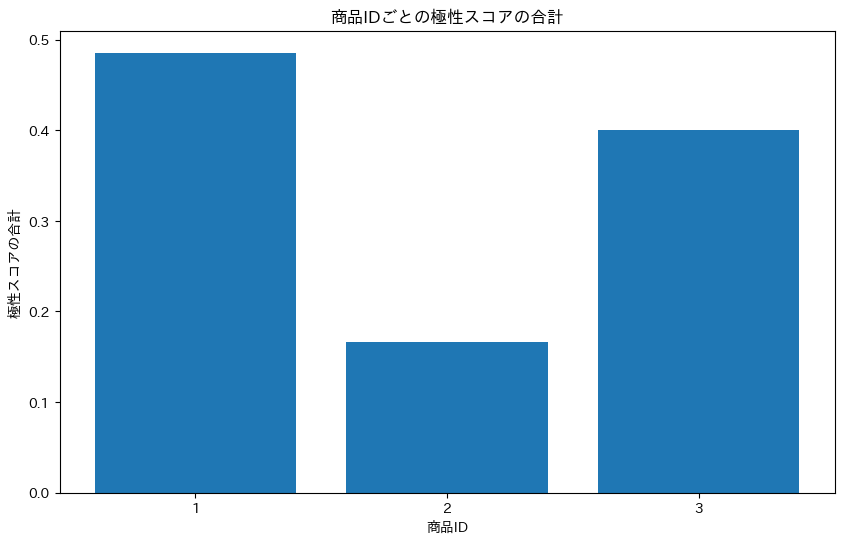

In [ ]:
df2['review_polarity'] = df2['レビュー本文'].apply(lambda text: text_polarity(text, polarity_dict=sentiment_dict_new))
# df2['商品ID'] = df2['商品ID'].astype(int)
df2.head()

IDs = []
polarities = []
for i in df2['商品ID'].unique():
    polarity = df2[df2['商品ID'] == i]['review_polarity'].sum()
    IDs.append(i)
    polarities.append(polarity)

plt.figure(figsize=(10, 6))  # グラフサイズを調整
plt.bar(np.array(IDs, dtype=np.int8), polarities)
plt.xticks(IDs)
plt.xlabel("商品ID")
plt.ylabel("極性スコアの合計")
plt.title(f"商品IDごとの極性スコアの合計")  # タイトルを追加
plt.show()

# 問題３：
投稿データを読み込み、投稿本文から動詞を抽出してください。 各ユーザーについて、出現頻度が高い上位5個の動詞を抽出し、折れ線グラフで可視化してください。 投稿本文をTF-IDFでベクトル化し、K-means法を用いてユーザーを3つのクラスタに分類してください。 各クラスタの特徴を分析し、クラスタに名前を付けてください。

In [ ]:
df3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/PKSHA/ex3.csv")
df3.head()

,投稿ID,ユーザーID,投稿本文
0,1,1,今日は天気が良かったので、公園でピクニックをしました。
1,2,2,新しいカフェに行ってきました。雰囲気が良くて、おすすめです。
2,3,1,最近、〇〇という本を読んでいます。とても面白いです。
3,4,3,〇〇という映画を観ました。感動しました。
4,5,2,今日は疲れたので、早く寝ます。


In [ ]:
df3['動詞'] = df3['投稿本文'].apply(lambda text: extract_words_by_pos(text, target_pos="動詞"))
df3.head()

,投稿ID,ユーザーID,投稿本文,動詞
0,1,1,今日は天気が良かったので、公園でピクニックをしました。,[する]
1,2,2,新しいカフェに行ってきました。雰囲気が良くて、おすすめです。,"[行く, くる]"
2,3,1,最近、〇〇という本を読んでいます。とても面白いです。,"[読む, いる]"
3,4,3,〇〇という映画を観ました。感動しました。,"[観る, する]"
4,5,2,今日は疲れたので、早く寝ます。,"[疲れる, 寝る]"


[('する', 2), ('行く', 1), ('くる', 1), ('読む', 1), ('いる', 1)]
('する', '行く', 'くる', '読む', 'いる') (2, 1, 1, 1, 1)


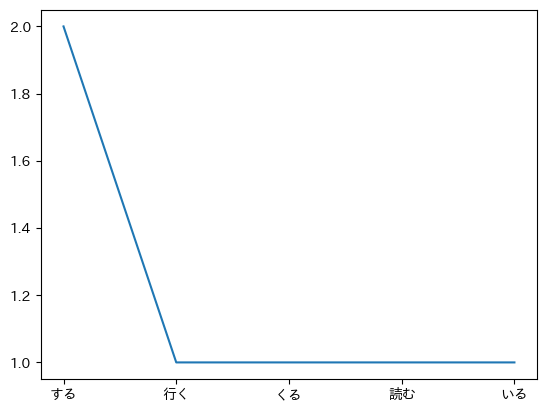

In [ ]:
all_verbs = [verb for verbs in df3['動詞'] for verb in verbs] # [verb 外ループ　内ループ]

top5_verbs = Counter(all_verbs).most_common(5)
print(top5_verbs)

words, counts = zip(*top5_verbs)
print(words, counts)

plt.figure()
plt.subplot(111) # figやaxはArtistと呼ばれるオブジェクトの一種です。
plt.plot(words, counts)

In [ ]:
# all_verbs = [verb for verb in verbs for verbs in df3['動詞']]
# print(top5_verbs)

# # ---------------------------------------------------------------------------
# # NameError                                 Traceback (most recent call last)
# # <ipython-input-23-f28af5e9e844> in <cell line: 1>()
# # ----> 1 all_verbs = [verb for verb in verbs for verbs in df3['動詞']]
# #       2 print(top5_verbs)

# # NameError: name 'verbs' is not defined

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df3['投稿本文'])

df3['vector'] = list(vectorizer.transform(df3['投稿本文']).toarray()) # こうすると一般的な配列の形になる
df3['vector']

,vector
0,"[0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, ..."
1,"[0.0, 0.0, 0.5773502691896258, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.5773502691896258, 0.0, 0.5773502691896..."
3,"[0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, ..."


In [ ]:
JAPANESE_STOP_WORDS = [
    "これ", "それ", "あれ", "この", "その", "あの", "ここ", "そこ", "あそこ", "で", "に", "を", "は", "が",
    "の", "た", "な", "も", "する", "ある", "いる", "そして", "から", "まで", "や", "など", "もの", "こと",
]


vectorizer = TfidfVectorizer(tokenizer=extract_words_by_pos, stop_words=JAPANESE_STOP_WORDS)
vectorizer.fit(df3['投稿本文'])

df3['vector'] = list(vectorizer.transform(df3['投稿本文']).toarray()) # こうすると一般的な配列の形になる
df3['vector']

"""
0	[0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, ...
1	[0.0, 0.0, 0.5773502691896258, 0.0, 0.0, 0.0, ...
2	[0.0, 0.5773502691896258, 0.0, 0.5773502691896...
3	[0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4	[0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, ...
"""
# TfidfVectorizer()を
# TfidfVectorizer(tokenizer=tokenizer, stop_words=JAPANESE_STOP_WORDS)と設定することで上の値から下の値に変わった
"""
0	[0.0, 0.0, 0.0, 0.0, 0.0, 0.4821401170833009, ...
1	[0.0, 0.38775666010579296, 0.38775666010579296...
2	[0.3393931489111758, 0.0, 0.0, 0.4206690600631...
3	[0.4222421409859579, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4222421409859...
   """

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'\n0\t[0.0, 0.0, 0.0, 0.0, 0.0, 0.4821401170833009, ...\n1\t[0.0, 0.38775666010579296, 0.38775666010579296...\n2\t[0.3393931489111758, 0.0, 0.0, 0.4206690600631...\n3\t[0.4222421409859579, 0.0, 0.0, 0.0, 0.0, 0.0, ...\n4\t[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4222421409859...\n   '

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0) # to instance
print(list(df3['vector']))
kmeans.fit(list(df3['vector']))
labels = kmeans.labels_ # get cluster_label
print(labels)

[array([0.        , 0.        , 0.        , 0.        , 0.48214012,
       0.38898761, 0.48214012, 0.48214012, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.38898761, 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0.38775666, 0.38775666, 0.        , 0.38775666, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.38775666, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.31283963, 0.38775666, 0.        , 0.        ,
       0.38775666, 0.        ]), array([0.       , 0.       , 0.4472136, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.4472136, 0.4472136, 0.       , 0.       , 0.       ,
       0.       , 0.4472136, 0.       , 0.4472136]), array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.5

In [ ]:
df3['tokens'] = df3['投稿本文'].apply(lambda text: extract_words_by_pos(text))
print(df3['tokens'])

0          [今日, 天気, 良い, 公園, ピクニック, する]
1    [新しい, カフェ, 行く, くる, 雰囲気, 良い, おすすめ]
2            [最近, 本, 読む, いる, とても, 面白い]
3                     [映画, 観る, 感動, する]
4                    [今日, 疲れる, 早い, 寝る]
Name: tokens, dtype: object


In [ ]:
df3['cluster'] = labels

cluster0_df = df3[df3['cluster'] == 0]
cluster1_df = df3[df3['cluster'] == 1]
cluster2_df = df3[df3['cluster'] == 2]

In [ ]:
# 各クラスタの特徴分析

# 投稿内容の確認: 各クラスタに属する投稿 (cluster0_df, cluster1_df, cluster2_df) の内容を実際に確認。

print(cluster0_df['投稿本文'].tolist())
print(cluster1_df['投稿本文'].tolist())
print(cluster2_df['投稿本文'].tolist())

# トークンの出現頻度分析: 各クラスタの df3['tokens'] を集計し、上位のトークン (単語) を確認。動詞だけでなく、名詞や形容詞なども含めて分析。

def count_tokens(df):
    all_tokens = []
    for tokens in df['tokens']:
        all_tokens.extend(tokens)
    return Counter(all_tokens)

print(count_tokens(cluster0_df).most_common(10))

['最近、〇〇という本を読んでいます。とても面白いです。', '今日は疲れたので、早く寝ます。']
['〇〇という映画を観ました。感動しました。']
['今日は天気が良かったので、公園でピクニックをしました。', '新しいカフェに行ってきました。雰囲気が良くて、おすすめです。']
[('最近', 1), ('本', 1), ('読む', 1), ('いる', 1), ('とても', 1), ('面白い', 1), ('今日', 1), ('疲れる', 1), ('早い', 1), ('寝る', 1)]


In [ ]:
# 1 TF-IDF ベクトルの分析: 各クラスタの中心ベクトル (セントロイド) を計算し、値の高い要素に対応する単語を確認。

cluster_centroids = kmeans.cluster_centers_
print(cluster_centroids) # 0,1,2に対応

# データセットに 1000 個のユニークな単語が含まれている場合、各文書の TF-IDF ベクトルは 1000 次元になります。centroid.argsort()[::-1] を使うことで、「各クラスタ」を特徴づける上位の単語のインデックスを簡単に取得できます。
def get_top_tfidf_words(centroid, top_n=5):
    top_indices = centroid.argsort()[::-1][:top_n]
    feature_names = vectorizer.get_feature_names_out()
    # print(f"{feature_names=}")
    return [feature_names[i] for i in top_indices]

print("Cluster 0 Top TF-IDF Words:", get_top_tfidf_words(cluster_centroids[0]))
print("Cluster 1 Top TF-IDF Words:", get_top_tfidf_words(cluster_centroids[1]))
print("Cluster 2 Top TF-IDF Words:", get_top_tfidf_words(cluster_centroids[2]))
# 2 共起ネットワーク分析: 各クラスタのトークン間の共起関係を分析し、ネットワークを可視化。
# 3 形態素解析結果の詳細な活用: 品詞情報 (df3['detailed_tokens']) を活用し、より詳細な分析 (例: 固有名詞の出現頻度)。
# 4 トピックモデル (LDA など) の適用: 各クラスタのトークンを用いてトピックモデルを学習し、各クラスタの話題を抽出。
# 上記の分析結果を総合的に判断し、各クラスタに適切な名前を付ける。例:

# 「イベント参加クラスタ」
# 「意見表明クラスタ」
# 「情報収集クラスタ」

[[0.         0.         0.2236068  0.         0.         0.21112107
  0.         0.         0.26167913 0.         0.         0.26167913
  0.         0.2236068  0.2236068  0.26167913 0.         0.
  0.         0.2236068  0.         0.2236068 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.57735027 0.         0.
  0.57735027 0.         0.         0.         0.         0.
  0.57735027 0.         0.         0.        ]
 [0.19387833 0.19387833 0.         0.19387833 0.24107006 0.19449381
  0.24107006 0.24107006 0.         0.         0.19387833 0.
  0.         0.         0.         0.         0.35091362 0.19387833
  0.         0.         0.19387833 0.        ]]
Cluster 0 Top TF-IDF Words: ['疲れる', '早い', '寝る', '面白い', '読む']
Cluster 1 Top TF-IDF Words: ['感動', '観る', '映画', '面白い', 'くる']
Cluster 2 Top TF-IDF Words: ['良い', 'ピクニック', '公園', '天気', '今日']


# 4 トピックモデル (LDA など) の適用: 各クラスタのトークンを用いてトピックモデルを学習し、各クラスタの話題を抽出。

LDA（Latent Dirichlet Allocation、潜在的ディリクレ配分法）は、文書集合に潜在するトピック（話題）を発見するための統計的モデルです。各文書は複数のトピックの混合で構成されており、各トピックは単語の確率分布で表現されるという考え方に基づいています。

LDAの適用手順

    0. 各クラスタのトークンリストを作成: 各クラスタに属する投稿のトークンリストを準備します。
    1. 辞書とコーパスを作成: gensim ライブラリを使用して、トークンリストから辞書とコーパスを作成します。
    2. LDAモデルの学習: gensim の LdaModel を使用して、LDAモデルを学習します。
    3. トピックの解釈: 学習されたモデルから各トピックの単語分布を確認し、トピックの意味を解釈します。


- コーパス（Corpus）

    目的: 実際の言語使用例を収集し、分析するためのデータを提供すること。
    内容: 大量のテキストデータ（文章、会話など）をコンピュータで処理しやすい形式で構造化したもの。
    構造: テキストデータに加えて、品詞情報、構文情報、意味情報などが付与されている場合もあります。
    例: 新聞記事のコーパス、ウェブテキストのコーパス、会話コーパスなど。

- コーパスの形式

    コーパスは、各文書を「(単語ID, 出現回数)」のタプルのリストで表現します。例えば、ある文書のトークンリストが ["単語1", "単語2", "単語1"] であり、辞書で「単語1」のIDが 0、「単語2」のIDが 1 である場合、その文書のコーパスは [(0, 2), (1, 1)] となります。これは、「単語1」が2回、「単語2」が1回出現していることを意味します。



In [ ]:
print(cluster0_df)

   投稿ID  ユーザーID                        投稿本文         動詞  \
2     3       1  最近、〇〇という本を読んでいます。とても面白いです。   [読む, いる]   
4     5       2             今日は疲れたので、早く寝ます。  [疲れる, 寝る]   

                                              vector  \
2  [0.0, 0.0, 0.4472135954999579, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.4222421409859579, ...   

                      tokens  cluster  
2  [最近, 本, 読む, いる, とても, 面白い]        0  
4          [今日, 疲れる, 早い, 寝る]        0  


In [ ]:
from gensim import corpora, models

# 各クラスタのトークンリストを作成
cluster0_tokens = [tokens for tokens in cluster0_df['tokens']]
cluster1_tokens = [tokens for tokens in cluster1_df['tokens']]
cluster2_tokens = [tokens for tokens in cluster2_df['tokens']]

dictionary = corpora.Dictionary(cluster0_tokens + cluster1_tokens + cluster2_tokens) # gensim.corpora.Dictionary は、単語とIDの対応関係を管理するためのクラスです。このクラスのコンストラクタには、トークンのリストのリストを渡す必要があります。
corpus0 = [dictionary.doc2bow(text) for text in cluster0_tokens]
corpus1 = [dictionary.doc2bow(text) for text in cluster1_tokens]
corpus2 = [dictionary.doc2bow(text) for text in cluster2_tokens]

# LDAモデルの学習 (例: クラスタごとにトピックモデルを作成)
num_topics=3
lda0 = models.LdaModel(corpus=corpus0, num_topics=num_topics, id2word=dictionary, random_state=42)
lda1 = models.LdaModel(corpus=corpus1, num_topics=num_topics, id2word=dictionary, random_state=42)
lda2 = models.LdaModel(corpus=corpus2, num_topics=num_topics, id2word=dictionary, random_state=42)

# 各トピックにおける単語の確率分布表示
print("Cluster 0 Topics:")
for topic_id, topic_words in lda0.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

print("\nCluster 1 Topics:")
for topic_id, topic_words in lda1.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

print("\nCluster 2 Topics:")
for topic_id, topic_words in lda2.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

"""
トピックモデルにおける「トピック」とは

トピックモデルでは、「トピック」とは、単語の確率分布で表現される概念です。つまり、各トピックは、そのトピックに属する可能性の高い単語とその確率の組で構成されています。

例えば、あるトピックが「旅行」に関する話題を表している場合、そのトピックは「旅行」「ホテル」「観光」「飛行機」「景色」などの単語に対して高い確率を持ち、それ以外の単語に対しては低い確率を持つような確率分布として表現されます。
"""

Cluster 0 Topics:
Topic 0: 0.094*"読む" + 0.094*"最近" + 0.094*"いる" + 0.094*"本" + 0.094*"面白い" + 0.094*"とても" + 0.026*"早い" + 0.026*"寝る" + 0.026*"今日" + 0.025*"疲れる"
Topic 1: 0.044*"疲れる" + 0.044*"今日" + 0.044*"早い" + 0.043*"寝る" + 0.043*"とても" + 0.043*"面白い" + 0.043*"いる" + 0.043*"最近" + 0.043*"本" + 0.042*"読む"
Topic 2: 0.109*"寝る" + 0.108*"疲れる" + 0.108*"今日" + 0.108*"早い" + 0.029*"とても" + 0.029*"本" + 0.029*"面白い" + 0.029*"読む" + 0.029*"最近" + 0.029*"いる"

Cluster 1 Topics:
Topic 0: 0.110*"映画" + 0.109*"観る" + 0.109*"感動" + 0.107*"する" + 0.028*"公園" + 0.028*"良い" + 0.028*"ピクニック" + 0.028*"行く" + 0.028*"天気" + 0.028*"くる"
Topic 1: 0.046*"する" + 0.045*"感動" + 0.044*"観る" + 0.043*"映画" + 0.041*"公園" + 0.041*"天気" + 0.041*"ピクニック" + 0.041*"行く" + 0.041*"カフェ" + 0.041*"良い"
Topic 2: 0.045*"する" + 0.044*"感動" + 0.044*"観る" + 0.043*"映画" + 0.041*"公園" + 0.041*"天気" + 0.041*"ピクニック" + 0.041*"行く" + 0.041*"カフェ" + 0.041*"良い"

Cluster 2 Topics:
Topic 0: 0.043*"良い" + 0.043*"公園" + 0.043*"カフェ" + 0.043*"ピクニック" + 0.043*"雰囲気" + 0.042*"今日" + 0.042*"おすすめ" 

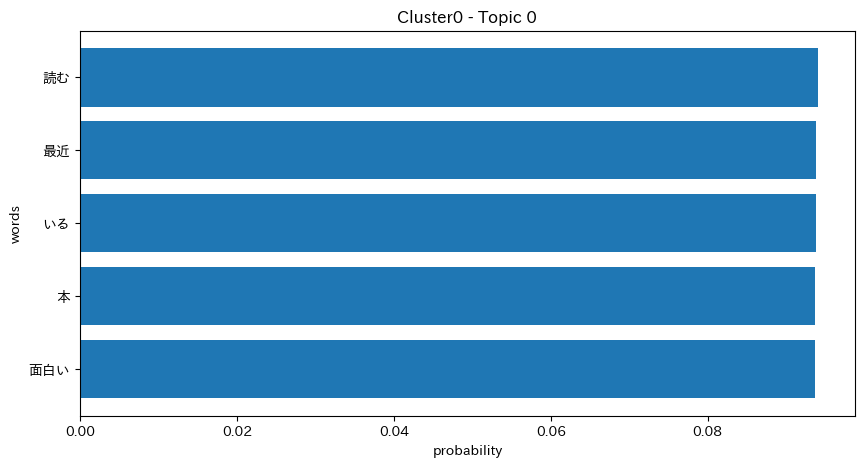

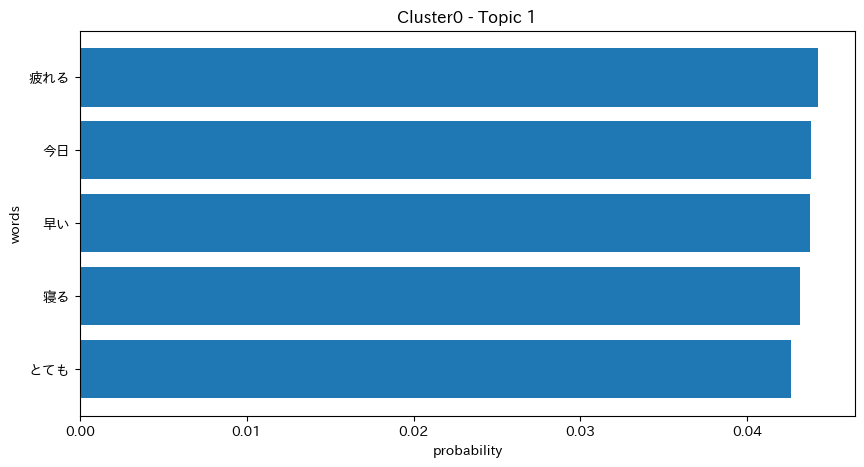

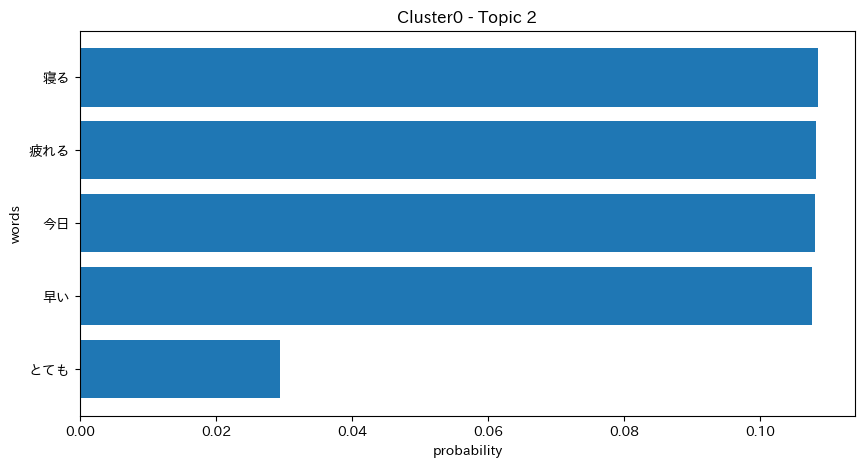

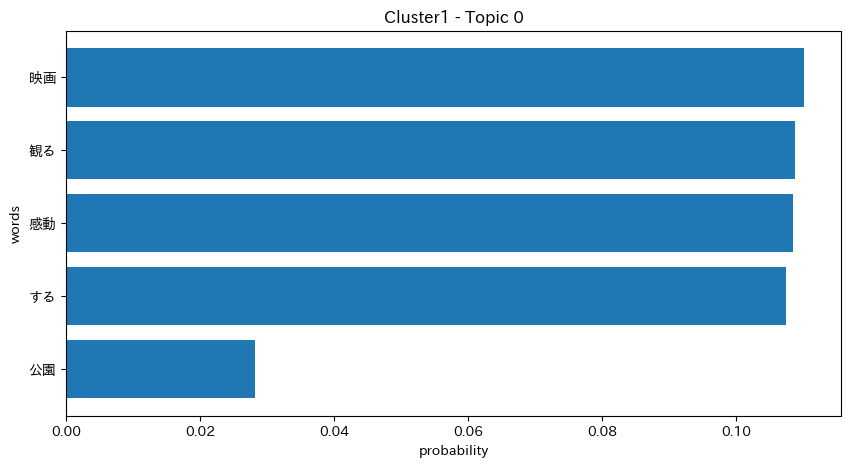

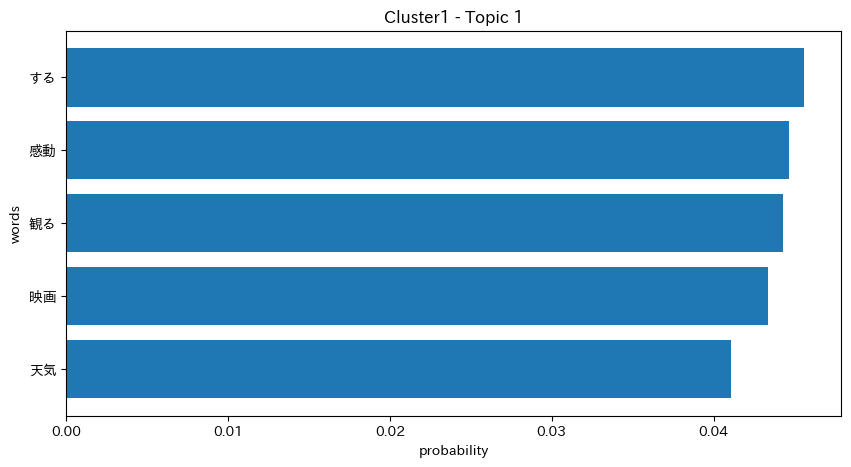

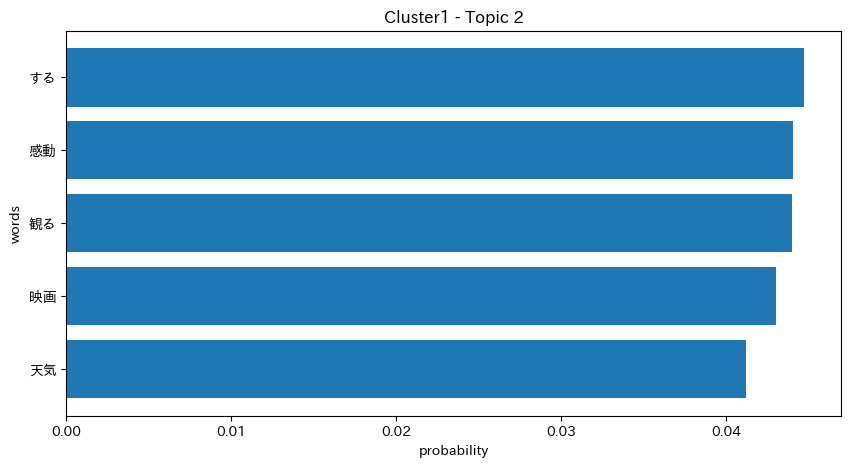

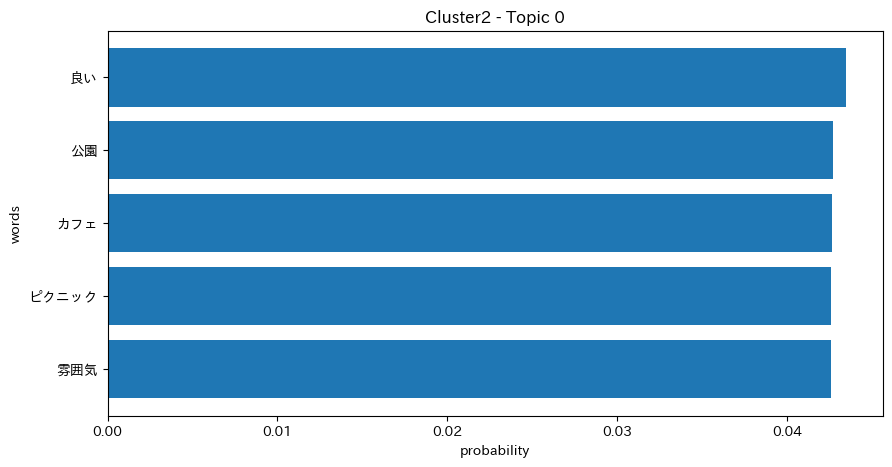

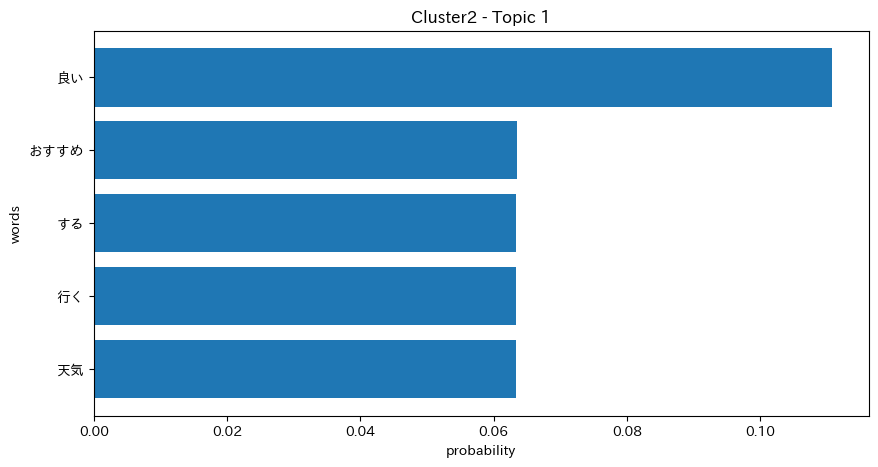

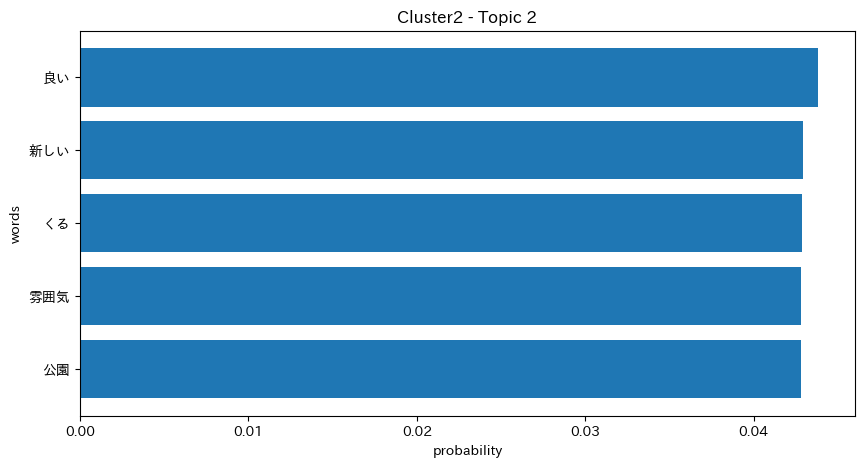

In [ ]:
# トピックの可視化
def visualize_topics(lda_model, dictionary, cluster_name):
    for topic_id in range(lda_model.num_topics):
        top_words = lda_model.show_topic(topic_id, topn=5) # 各トピックの上位5単語を取得
        # top_words = [("単語1", 0.200), ("単語2", 0.150), ("単語3", 0.100), ...]
        words, probs = zip(*top_words)

        plt.figure(figsize=(10, 5))
        plt.barh(words, probs)
        plt.title(f"{cluster_name} - Topic {topic_id}")
        plt.xlabel("probability")
        plt.ylabel("words")
        plt.gca().invert_yaxis()
        plt.show()

visualize_topics(lda0, dictionary, "Cluster0")
visualize_topics(lda1, dictionary, "Cluster1")
visualize_topics(lda2, dictionary, "Cluster2")